# 02 - Kanton Zürich Wärmenutzungsatlas - Erdwärmezonen
### Author: Daniel Herrera-Russert
#### February 03, 2025

In [1]:
# !pip install geopandas owslib requests pyproj fiona

In [30]:
import pandas as pd
import numpy as np
import os

from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import fiona
from shapely.ops import unary_union

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Loading the dataset

As part of the data obtained from the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) of Kanton Zürich, we now proceed with the extraction of the geographical dataset containing the data for ground heat usage. See the [metadata](https://www.geolion.zh.ch/geodatensatz/show?gdsid=316).


The data is retrieved from the GIS portal via WFS service, in order to obtain the separate layers preserving the geographic data qualities. Alternatively, it could be downloaded manually directly from the GIS download section in a variety of formats for different purposes.

### 1.1. Water protection zones

Following is the extraction and exploration of the dataset,corresponding to the layer containing the water protection zones.

In [3]:
# Define the WFS endpoint
WFS_URL = "https://maps.zh.ch/wfs/AwelGSWaermewwwZHWFS"

# Connect to the WFS service
wfs = WebFeatureService(WFS_URL, version="2.0.0")

# List available layers
print("Available layers:")
for layer in list(wfs.contents):
    print(layer)

Available layers:
ms:waermenutzung-zone-a
ms:waermenutzung-zone-b
ms:waermenutzung-zone-c
ms:waermenutzung-zone-d
ms:waermenutzung-zone-e
ms:waermenutzung-zone-f
ms:erdwaermesonden-auflagen
ms:tunnels-und-stollen
ms:erdwaermesonden
ms:sonden
ms:sammelschacht
ms:grundwasserpiezometer
ms:erdregister
ms:quellfassung-waermenutzung
ms:grundwasserfassung-waermenutzung
ms:quellfassung-ohne-waermenutzung
ms:grundwasserfassung-ohne-waermenutzung


In [4]:
# Define the list of layers to download
layers = [
    "ms:waermenutzung-zone-a",
    "ms:waermenutzung-zone-b",
    "ms:waermenutzung-zone-c",
    "ms:waermenutzung-zone-d",
    "ms:waermenutzung-zone-e",
    "ms:waermenutzung-zone-f",
]

# Define expected CRS (EPSG:2056 - LV95)
expected_crs = "EPSG:2056"

# Define output file
output_geojson = "data/raw/zh_waermenutzung_zonen.geojson"

# Create an empty list to store GeoDataFrames
gdfs = []

# Loop through layers and process each one
for layer in layers:
    print(f"Downloading {layer}...")
    
    # Request data in GML format
    response = wfs.getfeature(typename=layer, outputFormat="GML2")
    
    # Read the response as a GeoDataFrame
    gdf = gpd.read_file(BytesIO(response.read()))
    
    # Check and set CRS if missing
    if gdf.crs is None:
        gdf.set_crs(expected_crs, inplace=True)
    
    # Add a new column for the zone classification based on the layer name
    gdf["ZONEN"] = layer.replace("ms:waermenutzung-zone-", "").upper()
    
    # Append the processed GeoDataFrame to the list
    gdfs.append(gdf)

# Concatenate all layers into a single GeoDataFrame
merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Save the combined dataset as a GeoJSON file
merged_gdf.to_file(output_geojson, driver="GeoJSON")

print(f"All layers saved into '{output_geojson}' with CRS {expected_crs}")

All layers saved into 'data/raw/zh_waermenutzung_zonen.geojson' with CRS EPSG:2056


---

### 1.2. Restrictions (Auflagen)

In [5]:
# Define the restriction layer
restrictions_layer = "ms:erdwaermesonden-auflagen"

# Define output file
output_restrictions_geojson = "data/raw/zh_erdwaermesonden_auflagen.geojson"

print(f"Downloading {restrictions_layer}...")
response = wfs.getfeature(typename=restrictions_layer, outputFormat="GML2")
restrictions_gdf = gpd.read_file(BytesIO(response.read()))

# Check and set CRS if missing
if restrictions_gdf.crs is None:
    restrictions_gdf.set_crs(expected_crs, inplace=True)

# Save the dataset
restrictions_gdf.to_file(output_restrictions_geojson, driver="GeoJSON")

print(f"Restrictions saved as '{output_restrictions_geojson}' with CRS {expected_crs}")

Restrictions saved as 'data/raw/zh_erdwaermesonden_auflagen.geojson' with CRS EPSG:2056


In [6]:
# Load the datasets
zh_waermenutzung_gdf = gpd.read_file("data/raw/zh_waermenutzung_zonen.geojson")
zh_restrictions_gdf = gpd.read_file("data/raw/zh_erdwaermesonden_auflagen.geojson")

# Inspect the first few rows of each dataset
print("Thermal Zones:")
zh_waermenutzung_gdf.head()

Thermal Zones:


,gml_id,ZONEN,geometry
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858..."
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857..."
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347..."
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339..."
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ..."


In [7]:
print("\nRestrictions (Auflagen):")
zh_restrictions_gdf.head()


Restrictions (Auflagen):


,gml_id,zonen,geometry
0,erdwaermesonden-auflagen.107,Verbot,"POLYGON ((2678786.488 1249290.376, 2678785.911..."
1,erdwaermesonden-auflagen.108,Verbot,"POLYGON ((2679379.648 1248504.431, 2679379.044..."
2,erdwaermesonden-auflagen.109,Auflagen,"POLYGON ((2682120.057 1243256.662, 2682110.162..."
3,erdwaermesonden-auflagen.110,Auflagen,"POLYGON ((2699212.881 1268866.187, 2699212.924..."
4,erdwaermesonden-auflagen.111,Auflagen,"MULTIPOLYGON (((2679461.435 1247400.626, 26794..."


In [8]:
# Check unique zone classifications
print("\nUnique ZONEN values in Thermal Zones:", zh_waermenutzung_gdf["ZONEN"].unique())
print("\nUnique ZONEN values in Restrictions:", zh_restrictions_gdf["zonen"].unique())


Unique ZONEN values in Thermal Zones: ['A' 'B' 'C' 'D' 'E' 'F']

Unique ZONEN values in Restrictions: ['Verbot' 'Auflagen']


---

## 2. Structure of the Datasets

### **Thermal Usage Zones**
The `ZONEN` attribute categorizes areas based on **groundwater conditions** and their suitability for geothermal energy extraction:

- **B**: Gravel-based groundwater reservoirs, suitable for drinking water extraction.
- **B_Sperr**: Zone B with a restriction on geothermal probes.
- **C**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (high-yield aquifer).
- **C_Sperr**: Zone C with a restriction on geothermal probes.
- **D**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (low-yield aquifer).
- **D_Sperr**: Zone D with a restriction on geothermal probes.
- **E**: Spring water areas, suitable for drinking water extraction.
- **E_Sperr**: Zone E with a restriction on geothermal probes.
- **F**: Areas outside of usable groundwater reservoirs.
- **F_Sperr**: Zone F with a restriction on geothermal probes.
- **G**: Protection perimeter around drinking water intakes in the lower groundwater level.

This classification helps in **decision-making for geothermal energy projects**, ensuring compliance with **groundwater protection regulations** and identifying suitable locations for **geothermal probe installations**.

### **Geothermal Probe Restrictions (Erdwärmesonden Auflagen)**
The `zonen` attribute in this dataset categorizes areas based on **usage restrictions** for the construction of geothermal probes:

- **Auflagen**: Areas where geothermal probes are permitted but subject to specific conditions, detailed in the `BEMERKUNG` field.
- **Verbot**: Areas where geothermal probes are strictly prohibited, with explanations provided in the `BEMERKUNG` field.

Additional attributes:
- **`BEMERKUNG`**: Contains justifications for the classification as either **Auflagen** or **Verbot**.
- **`INFO_TXT`**: Provides further details on the nature of usage restrictions.
- **`OBJECTID`**: Unique identifier for each restricted area.
- **`SHAPE`**: Geometric representation of the restricted zones.

This classification is essential for ensuring **compliance with groundwater protection regulations** and guiding the **feasibility assessment of geothermal projects**.


---

### 2.1. Thermal Usage Zones Breakdown

This table from the legend of the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) outlines the **permissibility of different geothermal energy systems** based on **groundwater conditions** and **water protection zones**. The classification determines whether **geothermal probes (Erdwärmesonden), energy piles, and groundwater-based heating systems** are allowed or restricted.

The zone breakdown and protection levels from the data and the table below are based on the [Planning Guide](https://www.zh.ch/de/planen-bauen/bauvorschriften/energienutzung-untergrund-wasser/energie-aus-grundwasser.html) published in June 2010 by the **Amt für Abfall, Wasser, Energie und Luft (AWEL)** from the Baudirektion of Kanton Zürich. It provides an overview of the **energy potential** of underground and groundwater resources in the Canton of Zürich while ensuring the **protection of groundwater as a critical drinking water source**.

### Key Insights:
- **Zone A** (red) is a **strict protection area** where **all geothermal utilization is prohibited**.
- **Zones B-F** allow varying levels of geothermal use, with some restrictions.
- Areas marked **"S" (Schutzzone)** are the most restrictive, while **"Au" (outside protected zones)** are more flexible.
- **Erdwärmesonden (geothermal probes)** are **only permitted in Zones C, D, E, and F**.

### Geothermal Usage Permissions Table:

| **Groundwater Category**                                     | **Protection Zone** | **Zone** | **Geothermal Probes** | **Thermoactive Elements** | **Energy Registers (Fluid-Based)** | **Energy Registers (Air-Based)** | **Groundwater Heating** |
|-------------------------------------------------------------|--------------------|---------|---------------------|---------------------------|----------------------------------|----------------------------------|-------------------------|
| Gravel groundwater, suitable for drinking water extraction | S                  | A       | **Not Allowed (-)**  | **Not Allowed (-a)**      | **Not Allowed (-a)**            | **Not Allowed (-a)**            | **Not Allowed (-)**      |
| Gravel groundwater, suitable for drinking water extraction | Au                 | B       | **Not Allowed (-)**  | **Allowed (+b)**          | **Allowed (+b)**                | **Allowed (+d)**                | **Allowed (+e)**        |
| Gravel groundwater, unsuitable for drinking water extraction (high-yield) | Au | C | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Gravel groundwater, unsuitable for drinking water extraction (low-yield) | i.d.R. Au | D | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Spring water areas, suitable for drinking water extraction | Au | E | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+e)** |
| Areas outside of usable groundwater reserves | i.d.R. üb | F | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+g)** |

### Legend:
- **"-"**: Not allowed
- **"+(letter)"**: Allowed with conditions based on regulations. See the breakdown below.
- **S (Schutzzone)**: Strict water protection area
- **Au (Ausserhalb Schutzzone)**: Outside protection zones
- **i.d.R. Au**: Generally outside protection zones
- **i.d.R. üb**: Generally outside usable reserves

### +(letter) Restrictions:

- **(+a)**: Installations are allowed in **S3 and future S3 protection zones** if the bottom of the system is at least **2 meters above the highest groundwater level (HHW)**. Only **water or air as heat carriers** are permitted, and **direct evaporation systems are not allowed**.

- **(+b)**: The bottom of the installation must be **at least 2 meters above the highest groundwater level (HHW)** to ensure groundwater protection.

- **(+c)**: Installations are allowed but typically come **with additional requirements to protect the groundwater layer**. This may include **casing, sealing, or depth restrictions**.

- **(+d)**: The bottom of the installation must be positioned **above the mean groundwater level (MW)** to prevent interference with the water table.

- **(+e)**: A **minimum cooling capacity of 150 kW (or 100 kW for Minergie buildings)** is required. Other approval criteria are outlined in the **"Groundwater Energy Utilization"** regulations.

- **(+f)**: A **minimum cooling capacity of 50 kW** is required. Other approval conditions follow the **"Groundwater Energy Utilization"** guidelines.

- **(+g)**: **Small installations are allowed**, but groundwater-based heating systems are **generally not possible for hydrogeological reasons** (e.g., artesian conditions). Additional approval requirements apply.

- **Special conditions for geothermal probes**: Some zones have **specific additional requirements** for the use of geothermal probes.

- **Geothermal probes not allowed in certain areas**: In **specific hydrogeological conditions** (e.g., artesian groundwater), geothermal probes are **prohibited** due to potential water flow disruptions.

Based on this information, and given the use case of the project, the next step is applying this zone classification by reducing it into a relational table, which associates the zone ID letter with a description of its implications:

In [25]:
# Define restriction mapping
restriction_mapping = {
    "A": "Not allowed",
    "B": "Not allowed",
    "C": "Allowed with conditions (+c)",
    "D": "Allowed with conditions (+c)",
    "E": "Allowed with conditions (+c)",
    "F": "Allowed (+)"
}

# Apply mapping to create the 'restrictions' column
zh_waermenutzung_gdf["restrictions"] = zh_waermenutzung_gdf["ZONEN"].map(restriction_mapping)

# Display updated dataset
zh_waermenutzung_gdf.head()

,gml_id,ZONEN,geometry,restrictions
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858...",Not allowed
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857...",Not allowed
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347...",Not allowed
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339...",Not allowed
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ...",Not allowed


---

## 3. Visualizations

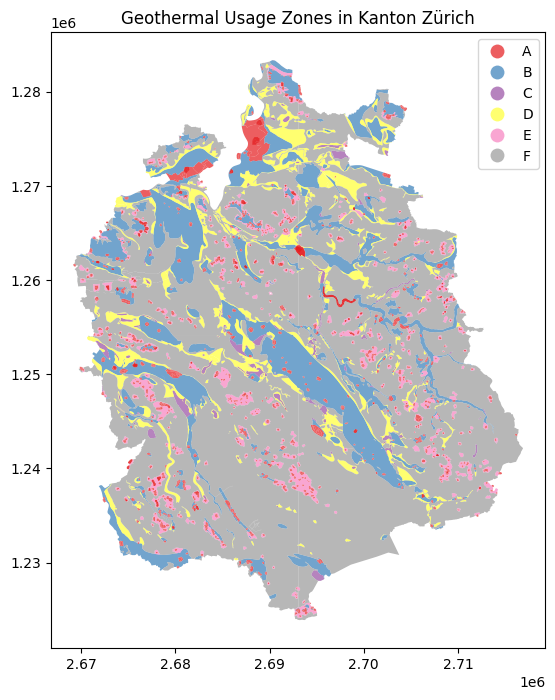

In [26]:
# Plot the dataset
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf.plot(ax=ax, column="ZONEN", cmap="Set1", legend=True, edgecolor=None, alpha=0.7)

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

The original dataset contains multiple layers and categories regarding various thermal energy extraction methods, such as groundwater heating and energy registers. However, for our specific analysis, which centers on geothermal probes, these additional categories introduce unnecessary complexity that can be simplified with fewer zone classifications.

The following plot focuses on the `restrictions` variable we have defined previously, in order to achieve the simplification. By filtering the dataset to display only the **restrictions for geothermal probes**, we created a more **clear and interpretable visualization**. The new color scheme—**green for allowed areas, orange for conditional approvals, and red for restricted zones**—ensures an intuitive understanding of where geothermal probes can be installed in the Zürich region.

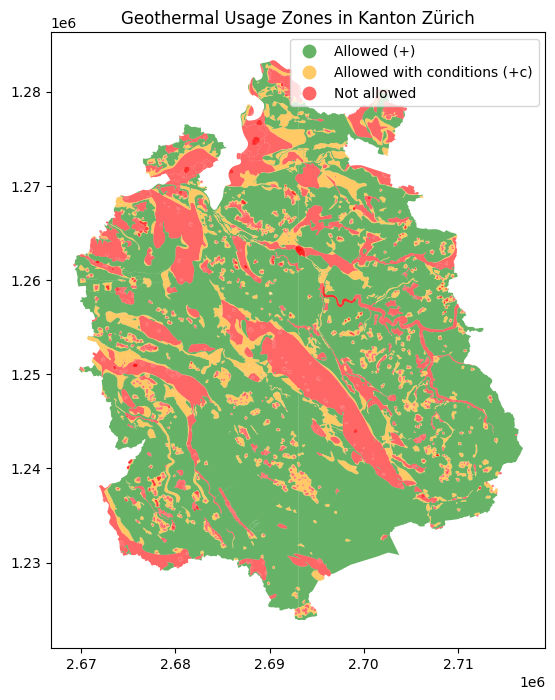

In [34]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Not allowed, conditions, allowed
categories = [ "Allowed (+)", "Allowed with conditions (+c)", "Not allowed",]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=0.6
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

An alpha factor has been deliberately added to the plot to show that **some areas appear to have overlapping polygons**, since there is a hierarchical structure to the different restriction classifications, creating unintended visual artifacts. This is due to the dataset containing **multiple layers of polygons that are not merged**, meaning that areas with the same restriction category (e.g., "Not allowed") were fragmented instead of being represented as a single, unified region. This overlap made it difficult to **interpret the spatial distribution of geothermal restrictions clearly** and could lead to misinterpretations in analysis.

To fix this, we use the **`.dissolve(by="restrictions")`** function to merge all polygons that share the same restriction category into a single geometry. However, this initially caused a **TopologyException** due to invalid geometries in the dataset. The issue was resolved by applying `.buffer(0)`, a common trick to clean self-intersecting or overlapping geometries without altering their spatial integrity. This allowed us to successfully merge the regions, resulting in a cleaner, more readable visualization where each restriction category is properly displayed as a single, unified area.

We also drop the `ZONEN` column, as it becomes irrelevant for the simple evaluation of whether a location is valid or not for a geothermal probe.

In [36]:
# Create a copy to preserve the original dataset
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf.copy()

# Ensure geometries are valid (fix invalid ones)
zh_waermenutzung_gdf_merged["geometry"] = zh_waermenutzung_gdf_merged["geometry"].buffer(0)

# Dissolve polygons by the 'restrictions' column
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.dissolve(by="restrictions")

# Reset index to avoid issues when plotting
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.reset_index()

# Drop the 'ZONEN' column as it's no longer needed
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.drop(columns=["ZONEN"], errors="ignore")

# Check the resulting dataset
zh_waermenutzung_gdf_merged.head()

,restrictions,geometry,gml_id
0,Allowed (+),"MULTIPOLYGON (((2674276.084 1231131.478, 26742...",waermenutzung-zone-f.226298
1,Allowed with conditions (+c),"MULTIPOLYGON (((2675512.502 1232303.526, 26755...",waermenutzung-zone-c.226278
2,Not allowed,"MULTIPOLYGON (((2672375.371 1236768.951, 26723...",waermenutzung-zone-a.1


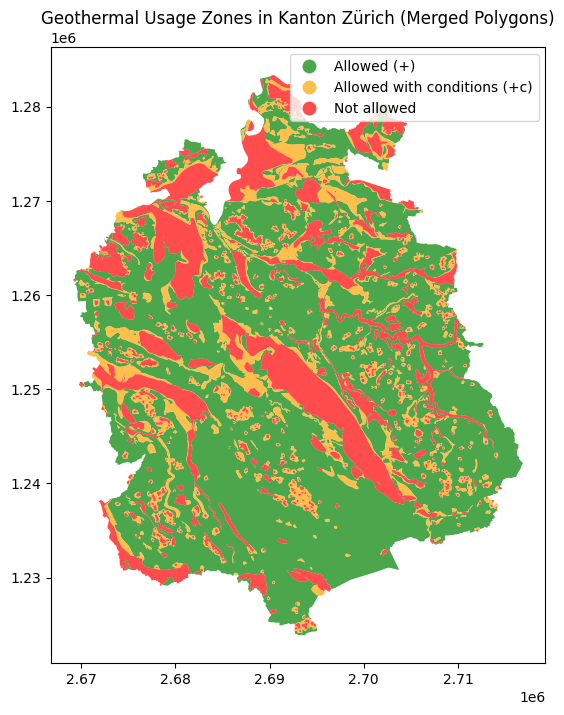

In [38]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Allowed, conditions, not allowed
categories = ["Allowed (+)", "Allowed with conditions (+c)", "Not allowed"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf_merged.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=0.7
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich (Merged Polygons)")

# Show plot
plt.show()

---

### Geothermal Probe Restrictions

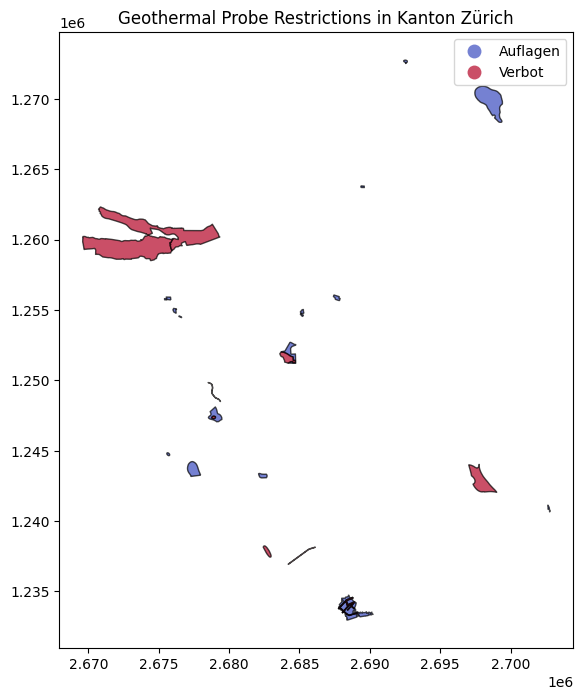

In [23]:
# Plot the restrictions dataset
fig, ax = plt.subplots(figsize=(10, 8))
zh_restrictions_gdf.plot(ax=ax, column="zonen", cmap="coolwarm", legend=True, edgecolor="black", alpha=0.7)

# Add title
ax.set_title("Geothermal Probe Restrictions in Kanton Zürich")

# Show plot
plt.show()